# Polymers

1 a)

Ved å lagre informasjonen i et N x 2 array, vil kjøretiden minke betraktelig. Siden vi bare er interresert i posisjonen til de N monomerene, og ikke hele gitteret, vil dette være den beste framgangsmåten. Vi oppretter et array med dimensjon N x 2, der hver rad inneholder informasjon om posisjonen til en monomer i polymeren. Den første kolonnen inneholder x-koordinaten til polymeren, og den andre y-koordinaten. 

TODO: Skriv akademisk

In [1]:
# Importing libraries
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from scipy.optimize import curve_fit
from scipy.spatial.distance import cdist

In [2]:
# 1b)
def createPolymer(n):
    """Inputs a number n and returns a horizontal polymer"""
    polymer = np.zeros((n,2))
    polymer[:,0] = np.linspace(0,n-1,n)
    polymer[:,1] = n//2
    return polymer

1c)
En rotatsjon om endepunktene vil ikke gi energiendring. Energiendring kommer av vekselvirkninger mellom monomerer som ligger inntil hverandre, men ikke er nabo-monomerer i selve polynomet.
Altså er det kun energiendring om enten som monomerer ligger i en avstand 1 unna hverandre flyttes fra hverandre, eller motsatt, hele tiden uten å være naboer i polynomet.

TODO: Skriv akademisk

In [3]:
def visualize_polymer(polymer):
    # Calculate the minimum and maximum coordinates of the polymer
    min_x = int(np.min(polymer[:, 0]))
    max_x = int(np.max(polymer[:, 0]))
    min_y = int(np.min(polymer[:, 1]))
    max_y = int(np.max(polymer[:, 1]))

    # Calculate grid dimensions based on the polymer coordinates
    grid_width = max_x - min_x + 1
    grid_height = max_y - min_y + 1
    grid_size = int(np.max([grid_height, grid_width]))
    cmap = ListedColormap(['white'] + plt.cm.viridis.colors)

    # Initialize the grid with zeros
    grid = np.zeros((grid_size, grid_size))

    # Plot the polymer on the grid
    # TODO: Vurder å prøve å kaste forløkka på sjøen
    for i, (x, y) in enumerate(polymer):
        grid[int(y - min_y), int(x - min_x)] = i + 1

    # Visualize the grid
    plt.figure(figsize=(8, 8))
    plt.pcolormesh(grid,  edgecolors='black', linewidth=0.5, cmap=cmap)
    plt.colorbar(label='Monomer ID')
    plt.xlabel('x-axis')
    plt.ylabel('y-axis')
    plt.show()

In [4]:
# 1e)

def isIntact(polymer, N):
    """Checks if a polymer is intact"""
    
    #Finner lengden av polymeret
    length = len(polymer)

    # Hvis lengden av monomeret er kortere enn n har vi "mistet" et monomer
    if length != N:
        return False

    #Finner lengden av uni_length som fjerner eventuelle duplikater i polymeret
    uni_length = len(np.unique(polymer, axis=0))

    if uni_length != length:
        return False

    #Sjekker om avstanden mellom hvert av monomerene er 1
    # TODO: Vurder å prøve å fjerne for
    for i in range(N-1): 
        x_dist = np.abs(polymer[i+1][0]-polymer[i][0])
        y_dist = np.abs(polymer[i+1][1]-polymer[i][1])
        distance = x_dist + y_dist
        if distance != 1:

            #Returnerer false dersom set_length er ulik length (duplikat-verdi i polymeret),
            #length er ulik n, eller monomerer er lenger enn 1 i avstand unna hverandre
            return False
    return True

In [5]:
#TODO: Skriv om vha. rotasjonsmatrise. Bruk (blant annet) dette som svar i 1h)
def createDirectionList(polymerPart):
    dir = np.zeros(len(polymerPart)-1)
    for i in range(len(polymerPart)-1):
        d = polymerPart[i+1] - polymerPart[i]
        # Right
        if d[0] == 1 and d[1] == 0:
            dir[i] = 0
        # Up
        elif d[0] == 0 and d[1] == 1:
            dir[i] = 1
        # Left
        elif d[0] == -1 and d[1] == 0:
            dir[i] = 2
        # Down
        elif d[0] == 0 and d[1] == -1:
            dir[i] = 3
        else:
            raise ValueError("Not valid distance")
    return dir


In [6]:
def rotatePolymer(p, coord, clockwise=True):
    """Inputs a polymer, a point, and an optional boolean, and rotates the polymer around that point
    Rotates clockwise if clockwise is true or not given, counterclockwise if false."""
    rotatingBase = -1
    polymer = np.copy(p)
    N = len(polymer)
    # finds index of monomer to rotate around
    for i in range(N):
        if np.array_equal(polymer[i], coord):
            rotatingBase = i
            break
    rotatingLeft = rotatingBase <= len(polymer)//2

    directionList = createDirectionList(polymer)
    if rotatingLeft:
        if clockwise:
            directionList[:rotatingBase] = (directionList[:rotatingBase] -1) % 4
        else:
            directionList[:rotatingBase] = (directionList[:rotatingBase] +1) % 4
    else:
        if clockwise:
            directionList[rotatingBase:] = (directionList[rotatingBase:] +1) % 4
        else:
            directionList[rotatingBase:] = (directionList[rotatingBase:] -1) % 4

    #IDEA: Calculate direction change for every polymer to be rotated. Then use this info to recalculate the position based of the rotation base.
    #print(directionList)

    if rotatingLeft:
        for i in range(rotatingBase - 1, -1, -1):
            polymer[i] = polymer[i+1]
            if directionList[i] == 0: # Right
                polymer[i][0] -= 1
            if directionList[i] == 1: # up
                polymer[i][1] -= 1
            if directionList[i] == 2: # left
                polymer[i][0] += 1
            if directionList[i] == 3: # down
                polymer[i][1] += 1
    else:
        for i in range(rotatingBase + 1, len(polymer)):
            polymer[i] = polymer[i - 1]
            if directionList[i - 1] == 0: # Right
                polymer[i][0] += 1
            if directionList[i - 1] == 1: # up
                polymer[i][1] += 1
            if directionList[i - 1] == 2: # left
                polymer[i][0] -= 1
            if directionList[i - 1] == 3: # down
                polymer[i][1] -= 1
    return polymer

In [7]:
#Rotate igjen
# Bruk i 1 h)

def rotatePolymer(polymer, coord, clockwise = True):
    """Inputs a polymer and rotates the short end in the direction specified around coord."""
    rotation_matrix =  np.array([[0, 1], [-1, 0]]) if clockwise else np.array([[0, -1], [1, 0]])
    # Find
    rotationCenterIdx = np.where((polymer == coord).all(axis=1))[0][0] #Gets index of polymer to rotate about.
    translated = polymer - coord
    rotated_polymer = np.copy(translated)
    if rotationCenterIdx <= len(polymer)//2:
        rotated_polymer[:rotationCenterIdx] = rotated_polymer[:rotationCenterIdx] @ rotation_matrix
    else:
        rotated_polymer[rotationCenterIdx + 1:] = rotated_polymer[rotationCenterIdx + 1:] @ rotation_matrix
    return rotated_polymer + coord

495


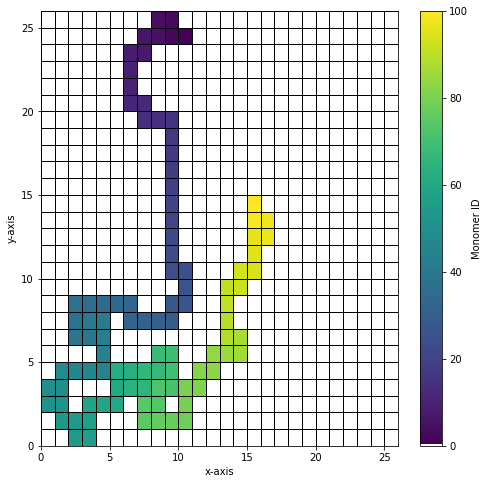

In [8]:
# 1g
# Calculate the minimum and maximum coordinates of the polymer
def testRotate(N, N_s):
    polymer = createPolymer(N)
    twisted_polymer = np.array([])
    succesRotations = 0

    for i in range(N_s):
        rotateMonomer = np.random.randint(1, N+1)
        rotateMonomer = polymer[rotateMonomer - 1]
        rotateDirection = np.random.randint(1,3)
        if rotateDirection == 1:
            twisted_polymer = rotatePolymer(polymer, rotateMonomer, clockwise = True)
            if isIntact(twisted_polymer, N) == True:
                succesRotations += 1 
                polymer = np.copy(twisted_polymer)
        if rotateDirection == 2:
             twisted_polymer = rotatePolymer(polymer, rotateMonomer, clockwise = False)
             if isIntact(twisted_polymer, N) == True:
                succesRotations += 1 
                polymer = np.copy(twisted_polymer)
        # visualize_polymer(polymer)

    
    return polymer, succesRotations

t = testRotate(100, 1000)
t1 = t[0]
t2 = t[1]
print(t2)
visualize_polymer(t1)


In [9]:
# TODO: Sett inn 1h her

In [10]:
#1i)
# Denne er treg. TODO: Sjekk om dette kan gjøres med 
def successRot(N_s):

    successRate = np.array([])

    for i in range(10, 1000, 10):
        successes = testRotate(i, N_s)[1]
        percentage = (successes / N_s) * 100
        successRate = np.append(successRate, percentage)

    return successRate

xVals = np.arange(10, 1000, 10)

yVals1000 = successRot(1000)

In [11]:
yVals2000 = successRot(2000)

/var/folders/y3/1w5k7p493sl56cbk6014g7mw0000gn/T/ipykernel_57348/452558594.py:3: RuntimeWarning: overflow encountered in exp
  return a * np.exp(-b * x) + c


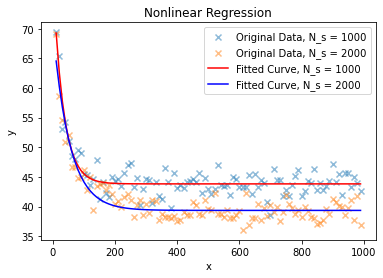

In [12]:
# Perform curve fitting
def func(x, a, b, c):
    return a * np.exp(-b * x) + c

popt1, pcov1 = curve_fit(func, xVals, yVals1000)
popt2, pcov2 = curve_fit(func, xVals, yVals2000)

# Extract optimized parameters
a_fit, b_fit, c_fit = popt1
d, e, f = popt2

# Generate y values using the fitted parameters
y_pred1000 = func(xVals, a_fit, b_fit, c_fit)
y_pred2000 = func(xVals, d, e, f)

# Plot the original data and the fitted curve
plt.scatter(xVals, yVals1000, marker="x", alpha=0.5, label='Original Data, N_s = 1000')
plt.scatter(xVals, yVals2000, marker="x", alpha=0.5, label='Original Data, N_s = 2000')
plt.plot(xVals, y_pred1000, 'r-', label='Fitted Curve, N_s = 1000')
plt.plot(xVals, y_pred2000, 'b-', label='Fitted Curve, N_s = 2000')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Nonlinear Regression')
plt.legend()
plt.show()

In [13]:
# 1j)

def calculateEnergy(polymer, V):
    b = cdist(polymer, polymer, 'cityblock') == 1
    energyMatrix = np.multiply(V,b)
    return np.sum(energyMatrix)/2

V = np.zeros([len(t1),len(t1)])
V[np.tril_indices_from(V,-2)] = -1
V[np.triu_indices_from(V,2)] = -1

print(calculateEnergy(t1,V))
    

-18.0


In [14]:
#2a)
# TODO: Kan denne effektiviseres?

def metropolis(polymer, N_s, V, T):
    beta = 1/(k_B*T)
    N = len(polymer)
    E_arr = np.zeros(N_s)
    E = calculateEnergy(polymer, V)
    E_arr[0] = E
    i = 0
    while i < N_s:
        xRand = np.random.randint(1, len(polymer))
        twist_coords = polymer[xRand]
        clockwise = bool(np.random.randint(0,2))
        twisted_polymer = rotatePolymer(polymer,twist_coords, clockwise)
        if isIntact(twisted_polymer, N):
            E_new = calculateEnergy(twisted_polymer, V)
            if E_new < E or np.random.uniform() < np.exp(-beta*(E_new - E)):
                polymer = np.copy(twisted_polymer)
                E = E_new
            E_arr[i] = E
            i += 1
            
    return polymer, E_arr
            


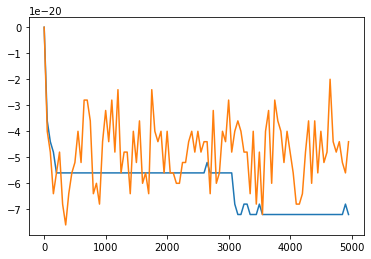

In [15]:
# 2b
# TODO: Fjern warnings

p1 = createPolymer(30)
p2 = np.copy(p1)
N_s = 5000
nonzero_E = -4e-21
k_B = 1.38e-23


V = np.zeros([len(p1),len(p1)])
V[np.tril_indices_from(V,-2)] = nonzero_E
V[np.triu_indices_from(V,2)] = nonzero_E

T_low = 75
T_high = 343

polymer_low, E_arr_low = metropolis(p1, N_s, V, T_low)
polymer_high, E_arr_high = metropolis(p2, N_s, V, T_high)

t = np.arange(0,len(E_arr_low))

plt.plot(t[::50],E_arr_low[::50])
plt.plot(t[::50],E_arr_high[::50])



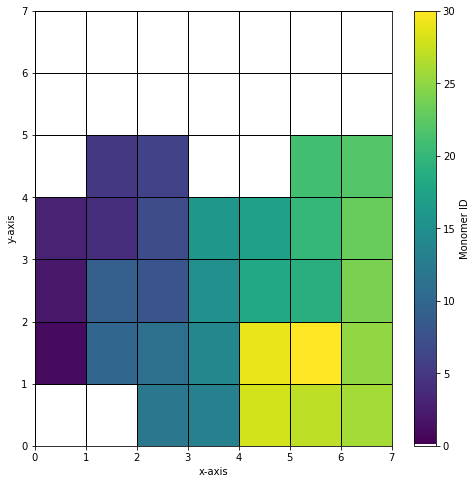

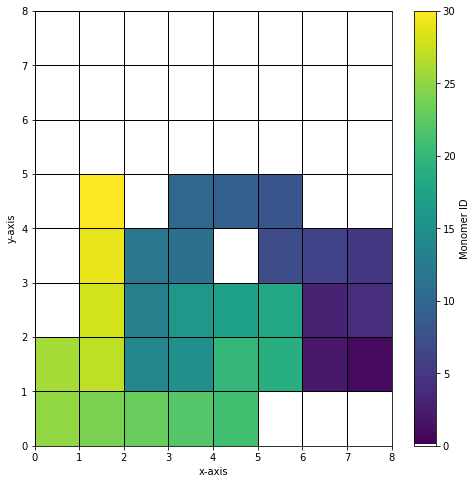

In [16]:
# 2c
visualize_polymer(polymer_low)
visualize_polymer(polymer_high)

[[-1.e+00 -1.e+00 -1.e+00 -1.e+00 -1.e+00 -1.e+00 -1.e+00 -1.e+00 -1.e+00
  -1.e+00 -1.e+00 -1.e+00 -1.e+00 -1.e+00 -1.e+00 -1.e+00 -1.e+00 -1.e+00
  -1.e+00 -1.e+00 -1.e+00 -1.e+00 -1.e+00 -1.e+00 -1.e+00 -1.e+00 -1.e+00
  -1.e+00 -1.e+00 -1.e+00]
 [-1.e+00 -1.e+01 -1.e+01 -1.e+01 -1.e+01 -1.e+01 -1.e+01 -1.e+01 -1.e+01
  -1.e+01 -1.e+01 -1.e+01 -1.e+01 -1.e+01 -1.e+01 -1.e+01 -1.e+01 -1.e+01
  -1.e+01 -1.e+01 -1.e+01 -1.e+01 -1.e+01 -1.e+01 -1.e+01 -1.e+01 -1.e+01
  -1.e+01 -1.e+01 -1.e+00]
 [-1.e+00 -1.e+01 -1.e+02 -1.e+02 -1.e+02 -1.e+02 -1.e+02 -1.e+02 -1.e+02
  -1.e+02 -1.e+02 -1.e+02 -1.e+02 -1.e+02 -1.e+02 -1.e+02 -1.e+02 -1.e+02
  -1.e+02 -1.e+02 -1.e+02 -1.e+02 -1.e+02 -1.e+02 -1.e+02 -1.e+02 -1.e+02
  -1.e+02 -1.e+01 -1.e+00]
 [-1.e+00 -1.e+01 -1.e+02 -1.e+03 -1.e+03 -1.e+03 -1.e+03 -1.e+03 -1.e+03
  -1.e+03 -1.e+03 -1.e+03 -1.e+03 -1.e+03 -1.e+03 -1.e+03 -1.e+03 -1.e+03
  -1.e+03 -1.e+03 -1.e+03 -1.e+03 -1.e+03 -1.e+03 -1.e+03 -1.e+03 -1.e+03
  -1.e+02 -1.e+01 -1.e+00]
 [-1

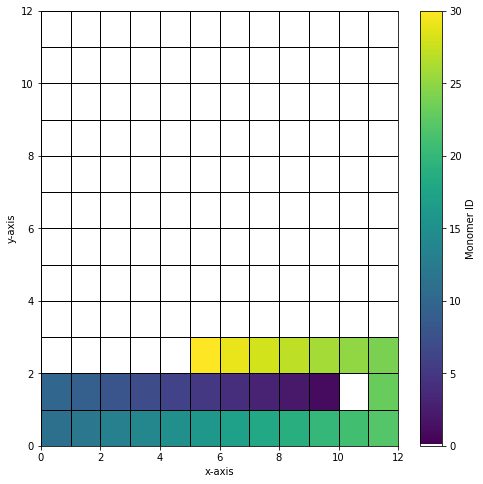

NameError: name 'getEuclideanDistance' is not defined

In [21]:
# 2d
#TODO: Denne matrisen stemmer ikke, diagonal != 0. Den er også lite interessant.
p3 = createPolymer(30)
V_d = -1*np.ones([len(p3), len(p3)])
for i in range(1, len(p3//2 + 1)):
    V_d[i:-i, i:-i] *=10
print(V_d)
polymer_d, E_d = metropolis(p3, 10000, V_d, 150)

visualize_polymer(polymer_d)

print(getEuclideanDistance(polymer_d))

In [26]:
# 2e
# Her er vi usikre på om alt er riktig
def test(N_s):
    pol = createPolymer(30)
    Temperature = np.arange(10, 1000, 30)
    energyArray = np.zeros([33, N_s - 1000])

    for i in range(len(Temperature)):
        energyArray[i] = metropolis(pol, N_s, V, Temperature[i])[1][1000:]

    return energyArray

Temperature = np.arange(10,1000,30)

In [19]:
runNs2000 = test(2000)
#runNs3000 = test(3000)
#runNs4000 = test(4000)

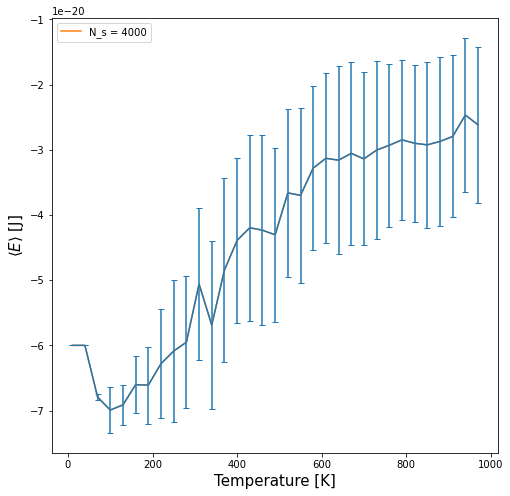

In [29]:
# TODO: Plott ved siden av hverandre, vurder å plotte ved siden av hverandre

meanRunNs2000 = np.mean(runNs2000, axis=1)
stdRunNs2000 = np.std(runNs2000, ddof=1, axis=1)

meanRunNs3000 = np.mean(runNs3000, axis=1)
stdRunNs3000 = np.std(runNs3000, ddof=1, axis=1)

meanRunNs4000 = np.mean(runNs4000, axis=1)
stdRunNs4000 = np.std(runNs4000, ddof=1, axis=1)

plt.figure(figsize=(8, 8))
# plt.errorbar(Temperature, meanRunNs2000, yerr=stdRunNs2000, fmt='-', capsize=3)
# plt.plot(Temperature, meanRunNs2000, label="N_s = 2000")
# plt.errorbar(Temperature, meanRunNs3000, yerr=stdRunNs3000, fmt='-', capsize=3)
# plt.plot(Temperature, meanRunNs3000, label="N_s = 3000")
plt.errorbar(Temperature, meanRunNs4000, yerr=stdRunNs4000, fmt='-', capsize=3)
plt.plot(Temperature, meanRunNs4000, label="N_s = 4000")
plt.xlabel('Temperature [K]', fontsize=15)
plt.ylabel('$\\langle E \\rangle$ [J]', fontsize=15)
plt.legend()
plt.show()

#print(yolo/len(yolo))

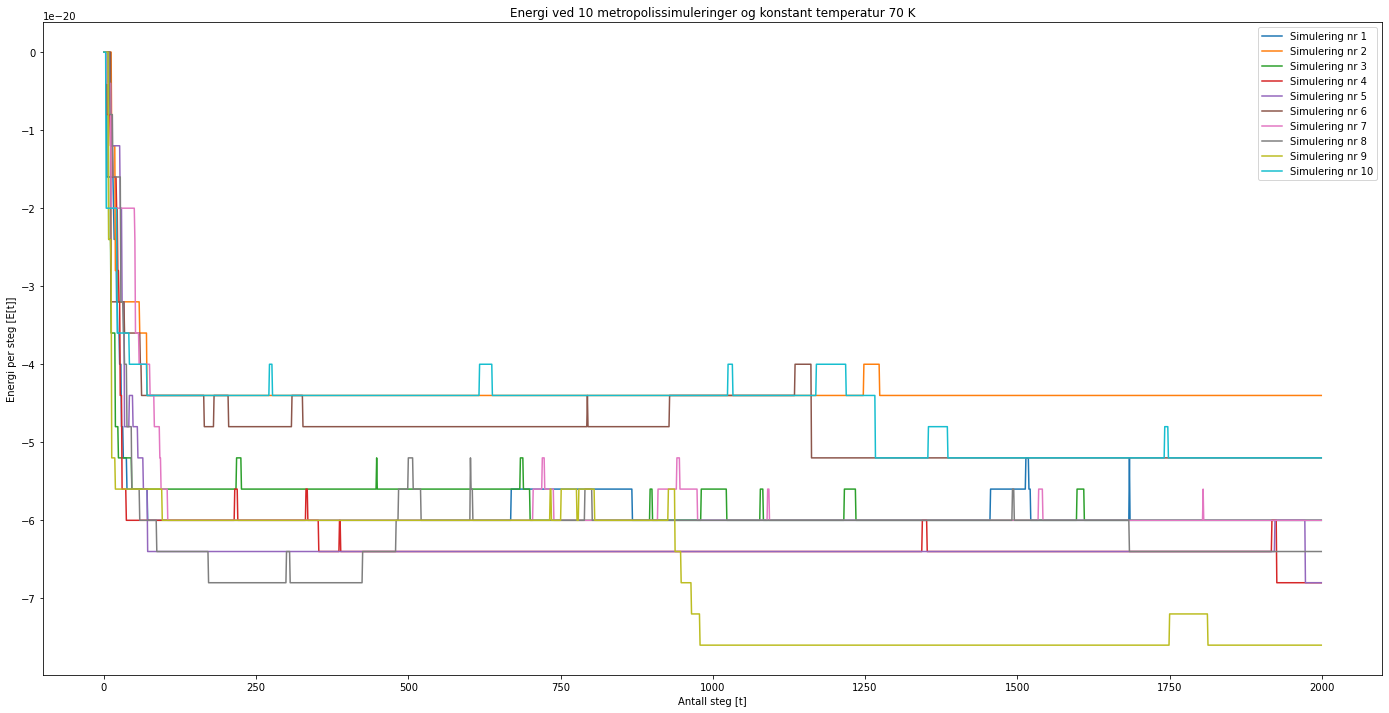

In [36]:
# 2f

T = 70 #K
N = 30 
N_s = 2000

def EnergyConstantT(T, N, N_s, V):
    i_arr = np.arange(0, N_s)
    plt.figure(figsize=(24, 12))
    plt.xlabel("Antall steg [t]")
    plt.ylabel("Energi per steg [E[t]]")
    plt.title(f"Energi ved 10 metropolissimuleringer og konstant temperatur {T} K")
    for i in range(1, 11):
        polymer = createPolymer(N)
        metro = metropolis(polymer, N_s, V, T)
        plt.plot(i_arr, metro[1], label = f"Simulering nr {i}")
    plt.legend()

EnergyConstantT(T, N, N_s, V)

In [31]:
# 2g

def getEuclideanDistance(polymer):
    return np.max(cdist(polymer, polymer, 'euclid'))

def metropolis_with_d(polymer, N_s, V, T):
    beta = 1/(k_B*T)
    N = len(polymer)
    E_arr = np.zeros(N_s)
    d_arr = np.zeros(N_s)
    E = calculateEnergy(polymer, V)
    E_arr[0] = E
    i = 0
    while i < N_s:
        xRand = np.random.randint(1, len(polymer))
        twist_coords = polymer[xRand]
        clockwise = bool(np.random.randint(0,2))
        twisted_polymer = rotatePolymer(polymer,twist_coords, clockwise)
        if isIntact(twisted_polymer, N):
            E_new = calculateEnergy(twisted_polymer, V)
            if E_new < E or np.random.uniform() < np.exp(-beta*(E_new - E)):
                polymer = np.copy(twisted_polymer)
                E = E_new
            E_arr[i] = E
            d_arr[i] = getEuclideanDistance(polymer)
            i += 1

    return polymer, E_arr, d_arr
            


In [33]:
# Define the interval
lower_bound = -6e-21
upper_bound = -2e-21

# Generate a random upper triangular matrix within the specified interval
random_matrix = (upper_bound - lower_bound) * np.random.rand(25, 25) + lower_bound
upper_triangular = np.triu(random_matrix, 1)

# Construct the symmetrical matrix by copying the upper triangular part to the lower triangular part
symmetrical_matrix = upper_triangular + upper_triangular.T

# Set the diagonal elements and the diagonals on each side of the main diagonal to zero
for i in range(25):
    symmetrical_matrix[i, i] = 0
    if i > 0:
        symmetrical_matrix[i, i-1] = 0
        symmetrical_matrix[i-1, i] = 0

print(symmetrical_matrix)

[[ 0.00000000e+00  0.00000000e+00 -3.96626838e-21 -4.54264086e-21
  -2.39081852e-21 -2.07527688e-21 -5.26465452e-21 -4.19628103e-21
  -3.88696277e-21 -5.34132393e-21 -2.33596951e-21 -3.34659480e-21
  -5.86119859e-21 -2.80396831e-21 -5.05252771e-21 -4.40898799e-21
  -4.99466694e-21 -3.71523406e-21 -5.16356029e-21 -5.72777042e-21
  -3.23721098e-21 -3.41122271e-21 -2.58487649e-21 -3.02412394e-21
  -2.00502329e-21]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 -3.81674007e-21
  -3.80530384e-21 -3.51517878e-21 -3.12952046e-21 -5.16519360e-21
  -4.37236819e-21 -3.72937150e-21 -2.20465150e-21 -3.65402602e-21
  -4.91182667e-21 -2.58154672e-21 -3.29965267e-21 -3.72560115e-21
  -3.64028428e-21 -5.74971571e-21 -5.15475022e-21 -4.60993305e-21
  -3.99954737e-21 -2.84304214e-21 -3.07426937e-21 -3.73647969e-21
  -5.00093331e-21]
 [-3.96626838e-21  0.00000000e+00  0.00000000e+00  0.00000000e+00
  -3.70146082e-21 -5.03096801e-21 -2.91472622e-21 -4.23209851e-21
  -3.50706310e-21 -2.86316461e-21 -3.6

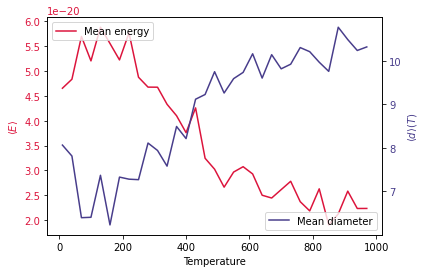

In [35]:
polly = createPolymer(25)
dArray = np.zeros([33, 1000])
eArray = np.zeros([33, 1000])
Temperature = np.arange(10, 1000, 30)

for i in range(len(Temperature)):
    dArray[i] = metropolis_with_d(polly, 2000, symmetrical_matrix, Temperature[i])[2][1000:]
    eArray[i] = metropolis_with_d(polly, 2000, symmetrical_matrix, Temperature[i])[1][1000:]


meansDArray = np.array([np.mean(subarray) for subarray in dArray])
meansEArray = np.array([np.mean(subarray) for subarray in eArray])


# Create figure and axes
fig, ax1 = plt.subplots()

# Plot on the first axes
ax1.plot(Temperature, np.abs(meansEArray), '-', label='Mean energy', color="crimson")
ax1.set_xlabel('Temperature')
ax1.set_ylabel('$\\langle E \\rangle$', color='crimson')
ax1.tick_params(axis='y', labelcolor='crimson')
ax1.legend(loc='upper left')

# Create a second axes that shares the same x-axis
ax2 = ax1.twinx()
ax2.plot(Temperature, meansDArray, '-', label='Mean diameter', color="darkslateblue")
ax2.set_ylabel('$\\langle d \\rangle (T)$', color='darkslateblue')
ax2.tick_params(axis='y', labelcolor='darkslateblue')
ax2.legend(loc='lower right')

plt.show()

In [ ]:
tester=metropolis_with_d(polly, 200, symmetrical_matrix, 40)[2][1000:]
ttet = np.mean(tester)
print(tester)

In [ ]:
def vetikkehvakalle(V, N_s, N, T, polymer):
    Temperature = np.arange(T, 10, -30)
    p = np.copy(polymer)
    d_arr = np.zeros(len(Temperature))
    for i in range(len(Temperature)):
        p, E, d = metropolis_with_d(p, N_s, V, Temperature[i])
        d_arr[i] = np.mean(d)
    print(d_arr)
    visualize_polymer(p)
    return d_arr, Temperature

d_arr, T = vetikkehvakalle(V, N_s, 30, 1000, createPolymer(30))
plt.plot(T,d_arr)


In [ ]:
def func2(x,a,b,c):
    return 1-a*np.exp(-b*x)+c
#scatter eller lineplot? Spør på veiledning
initial_guess = (1, 0.01, 1)

popt3, pcov3 = curve_fit(func2, T, d_arr, p0=initial_guess)
a_fit, b_fit, c_fit = popt3
predictedY = func2(T, a_fit,b_fit,c_fit)

plt.scatter(T, d_arr, marker="x", alpha=0.7, color="darkorange", label="Original Data")
plt.plot(T, predictedY, '-', color="seagreen", label="Fitted Curve")
plt.xlabel('x')
plt.ylabel('y')
plt.title("Nonlinear Regression")
plt.legend()
plt.show()